### PoC: 半分だけ用いればm求まるんじゃないかの検証
- 実験装置の都合上，画像上部の明るさは下部に比べて強い
    - 放物線だと思っていたが実は誤りの可能性
    - むしろmの式で表される曲線の方に近いかも
- 画像の半分の検出された部分でmを最適化により算出
    - 方針としてはまず2次曲線でフィッティング
    - detected boundaryを2次曲線の係数を用いて原点側にずらす
    - 最適化
- その後particle probabilityと照らし合わせる

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
# set params
U = [175, 200, 225, 250]
Q = [215, 304, 429]
D = [18, 24, 30]

# set dir
BINARY_DIR = '../data/binary/'
BOUNDARY_DIR = '../data/boundary/'

length = 10
x1 = 505
y1 = 447
x2 = 506
y2 = 530

z = 10 / np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [3]:
def detect_boundary(img, hei, wid, t=5):
    data = np.zeros((hei, 5))  # [index, start, end, flag, flag]

    # detection boundary
    for j in range(hei):
        data[j][0] = j  # index

        # detection from left side
        for i in range(wid - t):
            if np.all(img[j][i:i + t] == 255):
                data[j][1] = i
                data[j][3] = 1

                break

        # detection from right side
        if j > 700:
            for i in reversed(range(t, wid)):
                if np.all(img[j][i - t:i] == 255):
                    data[j][2] = i

                    if i > 1200:
                        data[j][4] = 0
                    else:
                        data[j][4] = 1

                    break

    return data

In [4]:
def model_func(x, *params):
    y = np.zeros_like(x)

    for i, param in enumerate(params):
        y += np.array(param * x ** i)

    return y

In [5]:
def fitting(data):
    a = np.zeros(1)
    b = np.zeros(1)

    for i in range(data.shape[0]):
        # left boundary
        if data[i, 3] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 1])

        # right boundary
        if data[i, 4] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 2])

    popt, pcov = curve_fit(model_func, b[1:], a[1:], p0=[1, 1, 1])

    return popt, pcov, a, b

In [46]:
bin_img = cv2.imread(BINARY_DIR + f'b_u_{175}_q_{215}_d_{18}_ppm_0.bmp', 0)
boundary = detect_boundary(img=bin_img, hei=1024, wid=1280)

In [47]:
popt, pcov, a, b = fitting(boundary[512:])

In [79]:
x = np.linspace(0, 1280-1, 1280)
y = popt[0] + popt[1] * x + popt[2] * x ** 2
X = x + popt[1] / popt[2] / 2
Y = y + (popt[1]**2 - 4 * popt[2] * popt[0]) / popt[2] / 4
A = a + popt[1] / popt[2] / 2
B = b + (popt[1]**2 - 4 * popt[2] * popt[0]) / popt[2] / 4

x *= z
y *= z
X *= z
Y *= -z
A *= -z
B *= z

m = 3142
theta_original = np.linspace(0, 2*np.pi, 1001)
theta = np.append(theta_original[1:500], theta_original[501:-1])

r = m * (np.pi - theta) / 175 / np.sin(theta)

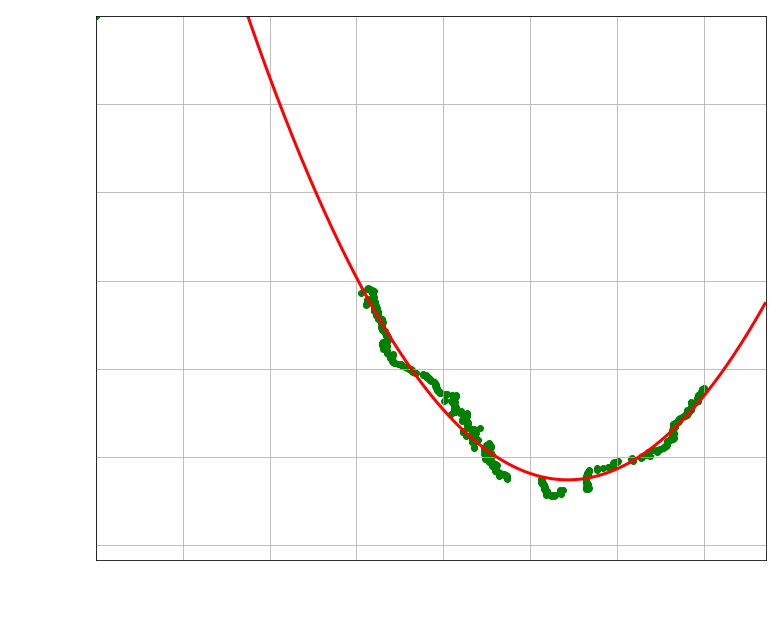

In [80]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.xlabel('$\it{x}$ [mm]', fontsize=28)
plt.ylabel('$\it{y}$ [mm]', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0, 1280*z)
plt.ylim(1024*z, 0)
plt.grid()

plt.plot(x, y, color='red', linewidth=3)
plt.scatter(b*z, a*z, c='g')
plt.show()

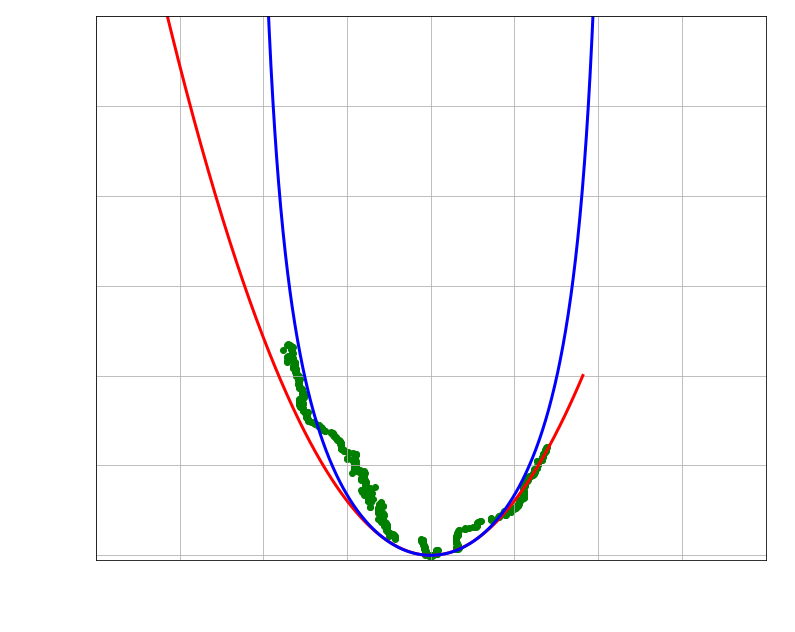

In [81]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.xlabel('$\it{x}$ [mm]', fontsize=28)
plt.ylabel('$\it{y}$ [mm]', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(-100, 100)
plt.ylim(-1, 120)
plt.grid()

plt.plot(X, Y, color='r', linewidth=3)
plt.plot(r * np.sin(theta), r * np.cos(theta) + m / 175, color='b', linewidth=3)

plt.scatter(B, A, c='g')
plt.show()

- $$ r = \frac{m(\pi-\theta)}{U\sin\theta} $$
- $$ y = \frac{x}{\tan(\pi-\frac{Ux}{m})} $$

In [77]:
def fit_m(u):
    def _model_func_m_xy(_x, _m):
        return _x / np.tan(np.pi - u * _x / _m)

    return curve_fit(_model_func_m_xy, B, A, p0=[3500])

In [78]:
popt_m, pcov_m = fit_m(175)